In [1]:
import clmm
from clmm import Cosmology
import numpy as np
import matplotlib.pyplot as plt

import sys
import h5py
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas
from scipy import integrate, signal
from scipy.stats import binned_statistic
from scipy.stats import norm
from scipy.special import erf
import astropy
import astropy.constants as const
import astropy.units as units
from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import FlatwCDM
from IPython.display import clear_output
import os
import corner
import emcee
from multiprocessing import Pool
from matplotlib.pyplot import cm
import time as pytime

cosmo = Cosmology(H0=71.0, Omega_dm0=0.3 - 0.045, Omega_b0=0.045, Omega_k0=0.0)
FlatwCDM(H0=71, Om0=0.2648, Ob0=0.04479, w0=-1.000000)

FlatwCDM(H0=71.0 km / (Mpc s), Om0=0.2648, w0=-1.0, Tcmb0=0.0 K, Neff=3.04, m_nu=None, Ob0=0.04479)

In [37]:
from scipy.interpolate import InterpolatedUnivariateSpline
def compute_delta_sigma_4theta(ell, r, mdelta, cdelta, z_cl, cosmo, hpmd='nfw', sample_N=10000, delta_mdef=200):

    ### DEFINING INTEGRALS:
    r_arr = np.linspace(0.01, 3*np.max(r), sample_N)
    sigma_0_arr = clmm.compute_surface_density(r_arr, mdelta, cdelta, z_cl, cosmo, delta_mdef=delta_mdef, 
                                     halo_profile_model=hpmd, massdef='mean', alpha_ein=None, 
                                     verbose=False, validate_input=True)
    eta_0_arr = np.gradient(np.log(sigma_0_arr),r_arr)*r_arr
    f = InterpolatedUnivariateSpline(r_arr, (r_arr**3)*sigma_0_arr*eta_0_arr, k=3)  # k=3 order of spline
    integral_vec = np.vectorize(f.integral)
    ###
    
    ### ACTUAL COMPUTATION:
    I_1 = (3/(r**4)) * integral_vec(0, r)
    sigma_0 = clmm.compute_surface_density(r, mdelta, cdelta, z_cl, cosmo, delta_mdef=200, 
                                     halo_profile_model=hpmd, massdef='mean', alpha_ein=None, 
                                     verbose=False, validate_input=True)
    #eta_0 = np.gradient(np.log(sigma_0),r)
    eta_0_interpolation_func = InterpolatedUnivariateSpline(r_arr, eta_0_arr)
    eta_0 = eta_0_interpolation_func(r) 
    
    
    return np.array((ell/4.0)*(2*I_1 - sigma_0*eta_0))

def compute_delta_sigma_const(ell, r, mdelta, cdelta, z_cl, cosmo, hpmd='nfw', sample_N=10000 ,delta_mdef=200):

    ### DEFINING INTEGRALS:
    r_arr = np.linspace(0.01, 3*np.max(r), sample_N)
    sigma_0_arr = clmm.compute_surface_density(r_arr, mdelta, cdelta, z_cl, cosmo, delta_mdef=delta_mdef, 
                                     halo_profile_model=hpmd, massdef='mean', alpha_ein=None, 
                                     verbose=False, validate_input=True)
    eta_0_arr = np.gradient(np.log(sigma_0_arr),r_arr)*r_arr
    f = InterpolatedUnivariateSpline(r_arr, sigma_0_arr*eta_0_arr/r_arr, k=3)  # k=3 order of spline
    integral_vec = np.vectorize(f.integral)
    ###
    
    ### ACTUAL COMPUTATION:
    I_2 = integral_vec(r, np.inf)
    sigma_0 = clmm.compute_surface_density(r, mdelta, cdelta, z_cl, cosmo, delta_mdef=delta_mdef, 
                                     halo_profile_model=hpmd, massdef='mean', alpha_ein=None, 
                                     verbose=False, validate_input=True)
    #eta_0 = np.gradient(np.log(sigma_0), r)*r
    eta_0_interpolation_func = InterpolatedUnivariateSpline(r_arr, eta_0_arr)
    eta_0 = eta_0_interpolation_func(r) 
    
    return np.array((ell/4.0)*(2*I_2 - sigma_0*eta_0))


def compute_delta_sigma_excess(ell, r, mdelta, cdelta, z_cl, cosmo, hpmd='nfw', sample_N=1000, delta_mdef=200):
    r_arr = np.linspace(0.01, 3*np.max(r), sample_N)
    sigma_0_arr = clmm.compute_surface_density(r_arr, mdelta, cdelta, z_cl, cosmo, delta_mdef=delta_mdef, 
                                     halo_profile_model=hpmd, massdef='mean', alpha_ein=None, 
                                     verbose=False, validate_input=True)
    eta_0_arr = np.gradient(np.log(sigma_0_arr),r_arr)*r_arr  
    eta_0_interpolation_func = InterpolatedUnivariateSpline(r_arr, eta_0_arr)
    eta_0 = eta_0_interpolation_func(r) 
    
    
    
    ## e^2 shenanigans:
    d_eta_0_arr_by_d_r = np.gradient(eta_0_arr,r_arr)*r_arr
    d_eta_0_arr_by_d_r_interpolation_func = InterpolatedUnivariateSpline(r_arr, d_eta_0_arr_by_d_r)
    d_eta_0_by_d_r = d_eta_0_arr_by_d_r_interpolation_func(r)
    
    correction_factor_arr = (ell**2*((1/8)*eta_0_arr + (1/16)*d_eta_0_arr_by_d_r + (1/16)*eta_0_arr**2))
    integrand = InterpolatedUnivariateSpline(r_arr, r_arr*sigma_0_arr*correction_factor_arr)
    
    integral_vec = np.vectorize(integrand.integral)
    ##
    
    ### ACTUAL COMPUTATION:
    I = (2/r**2)*integral_vec(0, r)
    
    #q=np.sqrt(2/(1+ell) - 1)
    
    s = clmm.compute_surface_density(r, mdelta, cdelta, z_cl, cosmo, delta_mdef=delta_mdef, 
                                     halo_profile_model=hpmd, massdef='mean', alpha_ein=None, 
                                     verbose=False, validate_input=True)
    
    correction_factor = (ell**2*((1/8)*eta_0 + (1/16)*d_eta_0_by_d_r + (1/16)*eta_0**2))
    ds_ell_square_correction = I - s*correction_factor

    
    return clmm.compute_excess_surface_density(r, mdelta, cdelta, z_cl, cosmo, delta_mdef=delta_mdef, 
                                     halo_profile_model=hpmd, massdef='mean', alpha_ein=None, 
                                     verbose=False, validate_input=True) + ds_ell_square_correction

In [47]:
## With emcee:
def log_likelihood_monopole(ds_mono,ds_mono_err, r_mono,params):
    sigma_c = 3.77988e+15
    z_cl=0.47
    z_gal=0.8
    mdelta,cdelta,ell,theta_e = params  # km/s
    
    ds_data = ds_mono
    
    #model:
    ds_model = compute_delta_sigma_excess(ell, r_mono, mdelta, cdelta, z_cl, cosmo=cosmo, hpmd='nfw', 
                                             sample_N=1000, delta_mdef=200)#/sigma_c
    
    # Gaussian likelihood:
    #sigma = np.full(len(r_mono), ds_model*0.01) 
    sigma = ds_mono_err
    term1 = -0.5*np.sum(np.log(2*np.pi*(sigma**2)))
    chi2 = ((ds_data - ds_model)**2 / (sigma)**2)
    term2 = -0.5*np.sum(chi2)

    return term1+term2

def log_likelihood_quadrupole_4theta(ds_quad_4theta,ds_quad_4theta_err, r_quad,params):
    sigma_c = 3.77988e+15
    z_cl=0.47
    z_gal=0.8
    mdelta,cdelta,ell,theta_e = params  # km/s
    
    ds_data = ds_quad_4theta
    
    #model:
    ds_model = compute_delta_sigma_4theta(ell, r_quad, mdelta, cdelta, z_cl, cosmo=cosmo, hpmd='nfw', 
                                             sample_N=1000, delta_mdef=200)#/sigma_c
    
    # Gaussian likelihood:
    #sigma = np.full(len(r_quad), ds_model*0.05) 
    sigma = ds_quad_4theta_err
    term1 = -0.5*np.sum(np.log(2*np.pi*sigma**2))
    chi2 = ((ds_data - ds_model)**2 / sigma**2)
    term2 = -0.5*np.sum(chi2)

    return term1+term2

def log_likelihood_quadrupole_const(ds_quad_const,ds_quad_const_err, r_quad,params):
    sigma_c = 3.77988e+15
    z_cl=0.47
    z_gal=0.8
    mdelta,cdelta,ell,theta_e = params  # km/s
    
    ds_data = ds_quad_const
    
    #model:
    ds_model = compute_delta_sigma_const(ell, r_quad, mdelta, cdelta, z_cl, cosmo=cosmo, hpmd='nfw', 
                                             sample_N=1000, delta_mdef=200)#/sigma_c
    
    # Gaussian likelihood:
    #sigma = np.full(len(r_quad), ds_model*0.05) 
    sigma = ds_quad_const_err
    term1 = -0.5*np.sum(np.log(2*np.pi*sigma**2))
    chi2 = ((ds_data - ds_model)**2 / sigma**2)
    term2 = -0.5*np.sum(chi2)

    return term1+term2

def priors(params, limits):
    
    a,b,c,d = params
    if (a < limits[0][0] or a > limits[0][1]):        #mdelta
        return -np.inf
    elif (b < limits[1][0] or b > limits[1][1]):      #cdelta
        return -np.inf
    elif (c < limits[2][0] or c > limits[2][1]):      #ell
        return -np.inf
    elif (d < limits[3][0] or d > limits[3][1]):      #sigma_int
        return -np.inf

    else:
        return 0.0

def log_posterior(params,gamma1, gamma2, x_arcsec, y_arcsec, sigma_c = 3.77988e+15):
    
    mdelta,cdelta,ell,theta_e = params
    #rotation:
    theta_e = theta_e*np.pi/180.0 # in radians
    gamma1,gamma2,x_arcsec,y_arcsec = halo_rotation(gamma1,gamma2,x_arcsec,y_arcsec,theta_e)
    
    #Prepare the data vector -> estimate delta sigma expansion terms
    ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err,ds_quad_const,ds_quad_const_err,r_quad = make_estimators(gamma1, gamma2, x_arcsec, y_arcsec, z_cl=0.47, sigma_c=3.77988e+15)
    
    #Evaluate the prior:
    prior=priors(params, limits)
    
    #Avoid likelihood evaluation when prior is -infinity:
    if prior == -np.inf:
        lnP = -np.inf
    else:
        lnP = prior + log_likelihood_monopole(ds_mono,ds_mono_err, r_mono,params) + log_likelihood_quadrupole_const(ds_quad_const,ds_quad_const_err, r_quad,params) + log_likelihood_quadrupole_4theta(ds_quad_4theta, ds_quad_4theta_err, r_quad,params)
        #log_likelihood_monopole(ds_mono,ds_mono_err, r_mono,params) +

    # safeguard against NaNs:
    if np.isnan(lnP):
        return -np.inf
    else:
        return lnP


In [48]:
def emcee_wrapper(gamma1, gamma2, x_arcsec, y_arcsec, z_cl, params_key, limits, true_value,
                 ndim, nwalkers, nsteps=1000, nburn=350, filename=None):  
    
    starting_guess_t=[]
    for i in np.arange(len(params_key)):
        guess=[]
        for j in np.arange(nwalkers):
            guess.append((limits[i][1]-limits[i][0])*np.random.random()+limits[i][0])
        starting_guess_t.append(guess)
    starting_guesses=np.column_stack(starting_guess_t)
    print('Starting guesses for ',nwalkers,' chains:')
    print(starting_guesses)
            
    start=pytime.time()
    
    if filename!=None:
        ## STORING THE CHAINS TO FILE
        backend = emcee.backends.HDFBackend(filename)
        backend.reset(nwalkers, ndim) ## Comment this line out to append steps to a previous run stored in the file
        with Pool() as pool:
            sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[gamma1, gamma2, x_arcsec, y_arcsec],
                                             vectorize=False, backend=backend, pool=pool)
            pos, prob, state = sampler.run_mcmc(starting_guesses, nsteps, progress=True)
            
    if filename==None:   
        ## RETURNING THE CHAINS WITHOUT STORING TO FILE
        with Pool() as pool:
            sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[gamma1, gamma2, x_arcsec, y_arcsec],
                                             vectorize=False, pool=pool)
            pos, prob, state = sampler.run_mcmc(starting_guesses, nsteps, progress=True)

    end=pytime.time()
    print("Time taken:{0:.1f} seconds".format(end-start))
            
    post = np.concatenate(sampler.chain[:, nburn: , :])
        
    #Corner plot:

    fig = plt.figure(figsize=[10,10])
    figure = corner.corner(post,labels=params_key, quantiles=[0.16, 0.5, 0.84], 
                           show_titles=True, title_fmt='.2e', fig=fig)
    figure.patch.set_facecolor('white')
    # Extract the axes
    axes = np.array(figure.axes).reshape((ndim, ndim))
    # Loop over the histograms
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(true_value[xi], color="r")
            ax.axhline(true_value[yi], color="r")
            ax.plot(true_value[xi], true_value[yi], "sr")
            #if yi == 1:
            #    ax.set_xlim([2000,2200])
    
    if f!=None:
        plt.savefig(filename[:-3]+"_corner_plot.png",facecolor="white", dpi="figure", format="png")       
    #Chain plot:

    color=iter(cm.rainbow(np.linspace(0,1,nwalkers)))
    # set up a plot with two windows, one for each parameter:
    plt.figure(figsize=(10,5))
    #plt.patch.set_facecolor('white')
    for i in range(len(params_key)):
        plt.subplot(100*len(params_key)+10+i+1)
        plt.ylabel(params_key[i], fontsize=10)
    for j in range(nwalkers):
        c=next(color)
        for i in range(len(params_key)):
            plt.subplot(100*len(params_key)+10+i+1)
            plt.plot(sampler.chain[j,nburn:,i], ',', color=c)
            
    if f!= None:
        plt.savefig(filename[:-3]+"_chain_plot.png",facecolor="white", dpi="figure", format="png")
    #A_fit = np.quantile((post[:,0].flatten()), 0.5)
    #A_std_fit = np.std(post[:,0].flatten())
    #A.append(A_fit)
    #A_err.append(A_std_fit)
    #print(A)
    #return np.array(A), np.array(A_err), z_final
    mean=[]
    err_minus=[]
    err_plus=[]
    for i in range(len(params_key)):
        mean.append(np.quantile((post[:,i].flatten()), 0.5))
        err_minus.append(np.quantile((post[:,i].flatten()), 0.16))
        err_plus.append(np.quantile((post[:,i].flatten()), 0.84))
    mean = np.array(mean)
    err_plus = np.array(err_plus) - mean
    err_minus = mean - np.array(err_minus)

    return post, mean, err_plus, err_minus

In [40]:
def Delta_Sigma_const(w, gamma1, Sigma_crit) :
	## TODO: sum over clusters
	return w * Sigma_crit * gamma1 / w

def Delta_Sigma_4theta(w1, w2, gamma1, gamma2, theta, Sigma_crit) :
	## TODO: sum over clusters
	return Sigma_crit * (w1*gamma1/np.cos(4*theta) + w2*gamma2/np.sin(4*theta)) / (w1 + w2)

def Delta_Sigma_4theta_cross(w1, w2, gamma1, gamma2, theta, Sigma_crit) :
	## TODO: sum over clusters
	return Sigma_crit * (w1*gamma1/np.cos(4*theta) - w2*gamma2/np.sin(4*theta)) / (w1 + w2)

def Delta_Sigma_const_cross(w, gamma2, Sigma_crit) :
	## TODO: sum over clusters
	return w*Sigma_crit*gamma2 / w

def weights(Sigma_crit, theta, Sigma_shape=0.0001, Sigma_meas=0) :
	## EQUATION 35, 32, 33
	w  = 1 / (Sigma_crit**2 * (Sigma_shape**2 + Sigma_meas**2))
	w1 = np.cos(4*theta)**2 * w
	w2 = np.sin(4*theta)**2 * w
	return w, w1, w2

def make_radial_bins(x, y, Nbins=10) :
	r = np.sqrt(x**2 + y**2)
	#r_bins = np.linspace(np.min(r), np.max(r), Nbins+1)
	rbin_edges = np.logspace(np.log10(0.4), np.log10(2.5), Nbins+1)
	inds = np.digitize(r, rbin_edges, right=True) - 1
	rbin_mean = np.array([np.mean(r[inds==i]) for i in range(Nbins)])
	return r, rbin_edges, rbin_mean, inds

def make_estimators(gamma1, gamma2, x_arcsec, y_arcsec, z_cl=0.3, sigma_c=3.77988e+15, method=1):
    r = np.sqrt((x_arcsec**2 + y_arcsec**2))
    theta = np.arctan2(y_arcsec, x_arcsec)
    #theta = theta - np.pi/2
    r_mpc = r*0.00588784182755241#cosmo.eval_da(z_cl)
    
    w, w1, w2 = weights(sigma_c, theta)
    DS4theta = Delta_Sigma_4theta(w1, w2, gamma1, gamma2, theta, sigma_c)
    DSconst = Delta_Sigma_const(w, gamma1, sigma_c)
    
    bins=10
    if method == 1 :
        ## METHOD 1 ##
        
        bin_edges = np.logspace(np.log10(0.4), np.log10(2.5), bins)
        N_i = []
        for i in np.arange(bins-1):
            N_i.append(len(r_mpc[(r_mpc > bin_edges[i]) & (r_mpc < bin_edges[i+1])]))
        N_i=np.array(N_i)


        result = binned_statistic(r_mpc, gamma1, statistic='mean', bins=bin_edges)
        gamma1_i = result.statistic
        res = binned_statistic(r_mpc, gamma2, statistic='mean', bins=bin_edges)
        gamma2_i = res.statistic
        res = binned_statistic(r_mpc, DS4theta, statistic='mean', bins=bin_edges)
        DS4theta_i_err = binned_statistic(r_mpc, DS4theta, statistic='std', bins=bin_edges).statistic/np.sqrt(N_i)
        DS4theta_i = res.statistic
        res = binned_statistic(r_mpc, DSconst, statistic='mean', bins=bin_edges)
        DSconst_i = res.statistic
        DSconst_i_err = binned_statistic(r_mpc, DSconst, statistic='std', bins=bin_edges).statistic/np.sqrt(N_i)

        r_i = bin_edges + (bin_edges[1]-bin_edges[0])
        
        bins_mono=15
        bin_edges = np.logspace(np.log10(0.4), np.log10(2.5), bins_mono)
        N_i = []
        for i in np.arange(bins_mono-1):
            N_i.append(len(r_mpc[(r_mpc > bin_edges[i]) & (r_mpc < bin_edges[i+1])]))
        N_i=np.array(N_i)
        
        r_mono = bin_edges + (bin_edges[1]-bin_edges[0])
        res = binned_statistic(r_mpc, gamma1*np.cos(2*theta), statistic='mean', bins=bin_edges)
        gammat_mono = -2*res.statistic
        ds_mono_err = 2*binned_statistic(r_mpc, gamma1*np.cos(2*theta), statistic='std', bins=bin_edges).statistic/np.sqrt(N_i)*sigma_c
        ds_mono = gammat_mono*sigma_c
        
    elif method == 2 :
        ## METHOD 2 ## -- DEPRECATED AS WE WANT DIFFERENT NUMBER OF BINS FOR MONOPOLE AND QUADRUPOLE

        Nbins = bins-1
        arcsec_to_Mpc = 0.00588784182755241
        r, rbin_edges, r_bins, r_inds = make_radial_bins(x_arcsec*arcsec_to_Mpc, y_arcsec*arcsec_to_Mpc, Nbins)

        ds_mono=[]
        ds_mono_err=[]
        delta_sigmas_4theta = []
        delta_sigmas_const = []
        delta_sigmas_4theta_cross = []
        delta_sigmas_const_cross = []
        delta_sigmas_4theta_err = []
        delta_sigmas_const_err = []
        delta_sigmas_4theta_cross_err = []
        delta_sigmas_const_cross_err = []
        for i in range(Nbins):
            select = (r_inds == i)
            theta_i = theta[select]
            gamma1_i = gamma1[select]
            gamma2_i = gamma2[select]
            w_i, w1_i, w2_i = weights(sigma_c, theta_i)
            DS4thetai = Delta_Sigma_4theta(w1_i, w2_i, gamma1_i, gamma2_i, theta_i, sigma_c)
            DSconsti = Delta_Sigma_const(w_i, gamma1_i, sigma_c)
            DS4thetacrossi = Delta_Sigma_4theta_cross(w1_i, w2_i, gamma1_i, gamma2_i, theta_i, sigma_c)
            DSconstcrossi = Delta_Sigma_const_cross(w_i, gamma2_i, sigma_c)
            DSmonoi = gamma1_i*np.cos(2*theta_i)*sigma_c

            ds_mono.append(-2*np.mean(DSmonoi))
            ds_mono_err.append(2*np.std(DSmonoi)/np.sqrt(len(DSmonoi)))
            delta_sigmas_4theta.append(np.mean(DS4thetai))
            delta_sigmas_4theta_err.append(np.std(DS4thetai)/np.sqrt(len(DS4thetai)))
            delta_sigmas_const.append(np.mean(DSconsti))
            delta_sigmas_const_err.append(np.std(DSconsti)/np.sqrt(len(DSconsti)))
            #delta_sigmas_4theta_cross.append([np.mean(DS4thetacrossi), np.std(DS4thetacrossi)/np.sqrt(len(DS4thetacrossi))])
            #delta_sigmas_const_cross.append([np.mean(DSconstcrossi), np.std(DSconstcrossi)/np.sqrt(len(DSconstcrossi))])

        r_i=np.array(rbin_edges + (rbin_edges[1]-rbin_edges[0]))
        r_mono=r_i
        ds_mono = np.array(ds_mono)
        ds_mono_err = np.array(ds_mono_err)
        DS4theta_i = np.array(delta_sigmas_4theta)
        DS4theta_i_err = np.array(delta_sigmas_4theta_err)
        DSconst_i = np.array(delta_sigmas_const)
        DSconst_i_err = np.array(delta_sigmas_const_err)

    return ds_mono,np.abs(ds_mono_err),r_mono[:-1],DS4theta_i,np.abs(DS4theta_i_err),DSconst_i,np.abs(DSconst_i_err),r_i[:-1]
    

Use rotation as given by equations 33~36 in man_glafic, ooguri et al. 

Writing the equations A.19, A.20 from Ooguri et al. (Manual for glafic):

$ \tilde{x} = x\cos(\theta_{e}) + y\sin(\theta_{e}) $\
$ \tilde{y} = -x\sin(\theta_{e}) + y\cos(\theta_{e}) $

And, equations A.33 through A.35:

$ \phi_{xx} = \phi_{\tilde{x}\tilde{x}} \cos^{2}(\theta_{e}) - 2 \phi_{\tilde{x}\tilde{y}}\sin(\theta_{e})\cos(\theta_{e}) + \phi_{\tilde{y}\tilde{y}} \sin^{2}(\theta_{e}) $\
$ \phi_{yy} = \phi_{\tilde{x}\tilde{x}} \sin^{2}(\theta_{e}) + 2 \phi_{\tilde{x}\tilde{y}}\sin(\theta_{e})\cos(\theta_{e}) + \phi_{\tilde{y}\tilde{y}} \cos^{2}(\theta_{e}) $\
$ \phi_{xy} = \phi_{\tilde{x}\tilde{x}}\sin(\theta_{e})\cos(\theta_{e}) + \phi_{\tilde{x}\tilde{y}}(\cos^{2}(\theta_{e}) - \sin^{2}(\theta_{e})) - \phi_{\tilde{y}\tilde{y}}\sin(\theta_{e})\cos(\theta_{e}) $

Original co-ordinates are x,y,$\gamma_{1}$,$\gamma_{2}$, while the major axis co-ordinates will be rotated by $\theta_{e}$ to give $\tilde{x}$,$\tilde{y}$,$\tilde\gamma_{1}$,$\tilde\gamma_{2}$ 

And, $\gamma_{1} = \dfrac{\phi_{xx} - \phi_{yy}}{2}$ ; $\gamma_{2} = \phi_{xy}$

Then:\
$\gamma_{1} = \tilde\gamma_{1}(\cos^{2}(\theta_{e}) - \sin^{2}(\theta_{e})) - 2\tilde\gamma_{2}\sin(\theta_{e})\cos(\theta_{e})$\
$\gamma_{2} = 2\tilde\gamma_{1}\sin(\theta_{e})\cos(\theta_{e}) + \tilde\gamma_{2}(\cos^{2}(\theta_{e}) - \sin^{2}(\theta_{e}))$

$\tilde\gamma_{1} = \gamma_{1}(\cos^{2}(\theta_{e}) - \sin^{2}(\theta_{e})) + 2\gamma_{2}\sin(\theta_{e})\cos(\theta_{e})$\
$\tilde\gamma_{2} = - 2\gamma_{1}\sin(\theta_{e})\cos(\theta_{e}) + \gamma_{2}(\cos^{2}(\theta_{e}) - \sin^{2}(\theta_{e}))$


In [41]:
def halo_rotation(gamma1,gamma2,x,y, theta_e):
    '''
    theta_e is the absolute rotation of the halo, assuming input halo is aligned along the x-axis
    '''
    x_tilde = x*np.cos(theta_e) + y*np.sin(theta_e)
    y_tilde = -1*x*np.sin(theta_e) + y*np.cos(theta_e)
    
    gamma1_tilde = gamma1*(np.cos(theta_e)**2 - np.sin(theta_e)**2) + 2*gamma2*np.sin(theta_e)*np.cos(theta_e)
    gamma2_tilde = -2*gamma1*np.sin(theta_e)*np.cos(theta_e) + gamma2*(np.cos(theta_e)**2 - np.sin(theta_e)**2)
    return gamma1_tilde,gamma2_tilde,x_tilde,y_tilde

In [42]:
dir_loc = "Elliptical_lenses_data/axis_ratio_9_10/"

gamma1 = np.load(dir_loc+"gamma1.npy").flatten()
gamma2 = np.load(dir_loc+"gamma2.npy").flatten()

x_arcsec = np.load(dir_loc+"x_arcsec.npy").flatten()
y_arcsec = np.load(dir_loc+"y_arcsec.npy").flatten()

#ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err,ds_quad_const,ds_quad_const_err,r_quad = make_estimators(gamma1, gamma2, x_arcsec, y_arcsec, z_cl=0.3, sigma_c=3.77988e+15)



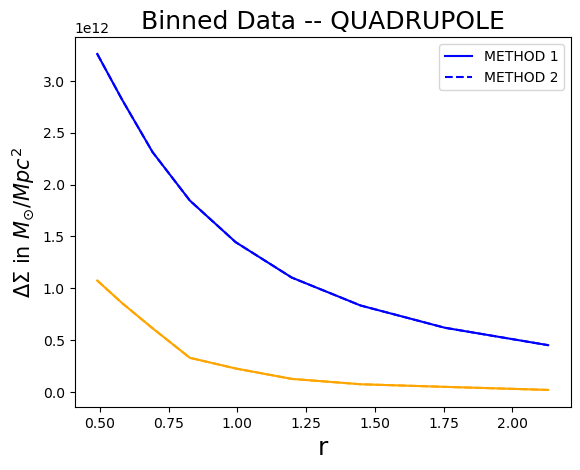

In [43]:
ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err,ds_quad_const,ds_quad_const_err,r_quad = make_estimators(gamma1, gamma2, x_arcsec, y_arcsec, z_cl=0.3, 
                                                                                                                      sigma_c=3.77988e+15, method=1)
plt.errorbar(r_quad, ds_quad_4theta, ls='solid', color='blue', label='METHOD 1')
plt.errorbar(r_quad, ds_quad_const, ls='solid', color='orange')

ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err,ds_quad_const,ds_quad_const_err,r_quad = make_estimators(gamma1, gamma2, x_arcsec, y_arcsec, z_cl=0.3, 
                                                                                                                      sigma_c=3.77988e+15, method=2)
plt.errorbar(r_quad, ds_quad_4theta, ls='dashed', color='blue', label='METHOD 2')
plt.errorbar(r_quad, ds_quad_const, ls='dashed', color='orange')
#plt.xlim(0.2,0.5)
plt.xlabel('r', fontsize=18)
plt.title('Binned Data -- QUADRUPOLE',fontsize=18)
plt.ylabel('$\Delta\Sigma$ in $M_{\odot}/Mpc^2$', fontsize=15)
plt.legend()

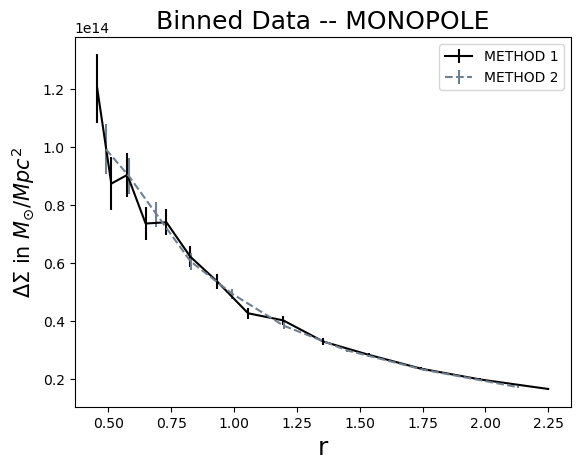

In [44]:
ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err,ds_quad_const,ds_quad_const_err,r_quad = make_estimators(gamma1, gamma2, x_arcsec, y_arcsec, z_cl=0.3, 
                                                                                                                      sigma_c=3.77988e+15, method=1)
plt.errorbar(r_mono, ds_mono, yerr=ds_mono_err, ls='solid', color='black', label='METHOD 1')

ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err,ds_quad_const,ds_quad_const_err,r_quad = make_estimators(gamma1, gamma2, x_arcsec, y_arcsec, z_cl=0.3, 
                                                                                                                      sigma_c=3.77988e+15, method=2)
plt.errorbar(r_mono, ds_mono, yerr=ds_mono_err, ls='dashed', color='slategray', label='METHOD 2')

#plt.xlim(0.2,0.5)
plt.xlabel('r', fontsize=18)
plt.title('Binned Data -- MONOPOLE',fontsize=18)
plt.ylabel('$\Delta\Sigma$ in $M_{\odot}/Mpc^2$', fontsize=15)
plt.legend()

In [45]:
#3.77988e+15
print(cosmo.eval_sigma_crit(0.3,0.63))
print(cosmo.eval_da(0.47) * np.pi/180.0 * 1/3600)

3824860613936461.0
0.005816313203836024


<font size=6> Plotting Shears and their ARBITRARY ROTATION: </font>

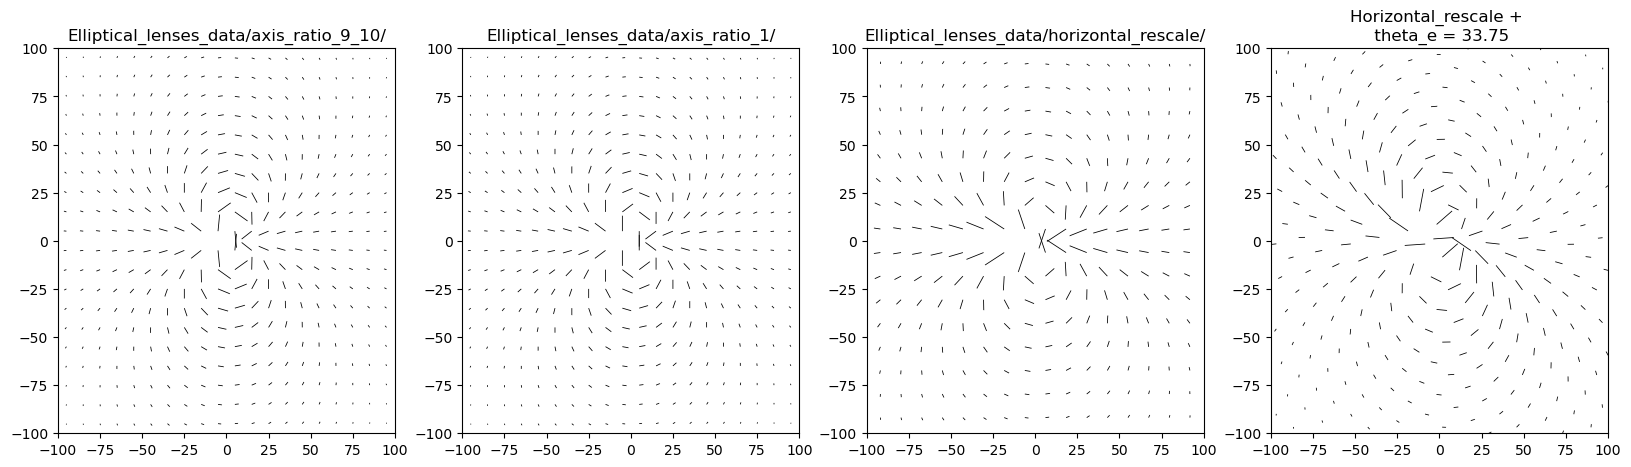

In [32]:
import matplotlib.pyplot as plt
import numpy as np

dir_loc_arr = ["Elliptical_lenses_data/axis_ratio_9_10/","Elliptical_lenses_data/axis_ratio_1/","Elliptical_lenses_data/horizontal_rescale/", "transform"]
n=len(dir_loc_arr)
size=5#int(5/(n-2))
plt.figure(figsize=[n*size,size])
for i,dir_loc in enumerate(dir_loc_arr):
    if dir_loc == "transform":
        plt.subplot(int(10*n)+100+i+1)
        
        theta_e = np.pi/4-np.pi/16 # in radians
        gamma1,gamma2,x_arcsec,y_arcsec = halo_rotation(gamma1,gamma2,x_arcsec,y_arcsec,theta_e)
        q = plt.quiver(x_arcsec, y_arcsec, gamma1, gamma2, headwidth=0)
        plt.xlim([-100,100])
        plt.ylim([-100,100])
        plt.title("Horizontal_rescale + \n theta_e = "+str(theta_e*180.0/np.pi))
    
    else: 
        
        plt.subplot(int(10*n)+100+i+1)
        gamma1 = np.load(dir_loc+"gamma1.npy").flatten()
        gamma2 = np.load(dir_loc+"gamma2.npy").flatten()

        x_arcsec = np.load(dir_loc+"x_arcsec.npy").flatten()
        y_arcsec = np.load(dir_loc+"y_arcsec.npy").flatten()



        X = np.arange(-10, 10, 1)
        Y = np.arange(-10, 10, 1)
        U, V = np.meshgrid(X, Y)

        #plt.figure(figsize=[7,7])
        #fig, ax = plt.subplots()

        q = plt.quiver(x_arcsec, y_arcsec, gamma1, gamma2, headwidth=0)
        #ax.quiverkey(q, X=0.3, Y=1.1, U=10,
        #             label='Quiver key, length = 10', labelpos='E')


        plt.xlim([-100,100])
        plt.ylim([-100,100])
        plt.title(dir_loc)
#plt.show()

Starting guesses for  12  chains:
[[ 2.74857938e+14  1.13608912e+01 -7.55816637e-01  2.75443075e+01]
 [ 3.57879494e+14  1.85119328e+01  2.77043622e-01  2.77620299e+01]
 [ 3.01778925e+14  1.42072116e+00 -7.06160491e-01  4.24686635e+01]
 [ 2.72896708e+14  1.74258599e+00  8.80444456e-01  3.06819135e+01]
 [ 2.12403745e+14  4.04367949e-01  4.32596771e-02  1.61778555e+01]
 [ 3.23301162e+14  1.66523969e+01 -1.68969359e-01  1.96664379e+01]
 [ 2.19356018e+14  1.55631350e+01 -4.66179888e-01  3.13934038e+01]
 [ 4.45994727e+14  1.74002430e+01  5.42982705e-01  2.71014622e+00]
 [ 4.81867717e+14  1.95723668e+01 -8.68223422e-02  3.00045022e+01]
 [ 1.92337318e+14  1.59831713e+01  1.35499219e-01  3.01787041e+01]
 [ 3.96070794e+14  9.22958725e+00 -9.52796195e-01  9.46721525e+00]
 [ 2.64918565e+14  1.56105835e+01  2.32918284e-01  5.80168339e+00]]


100%|██████████| 6000/6000 [02:26<00:00, 40.82it/s]


Time taken:147.6 seconds


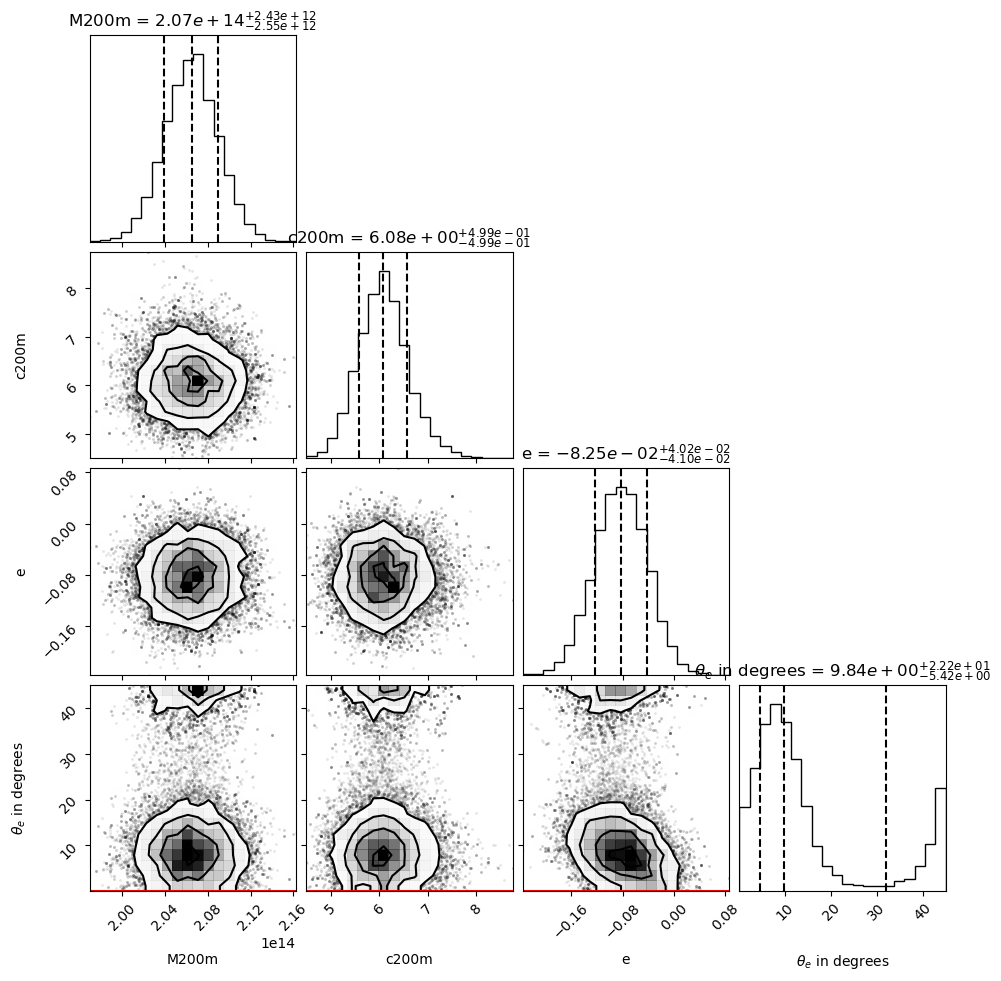

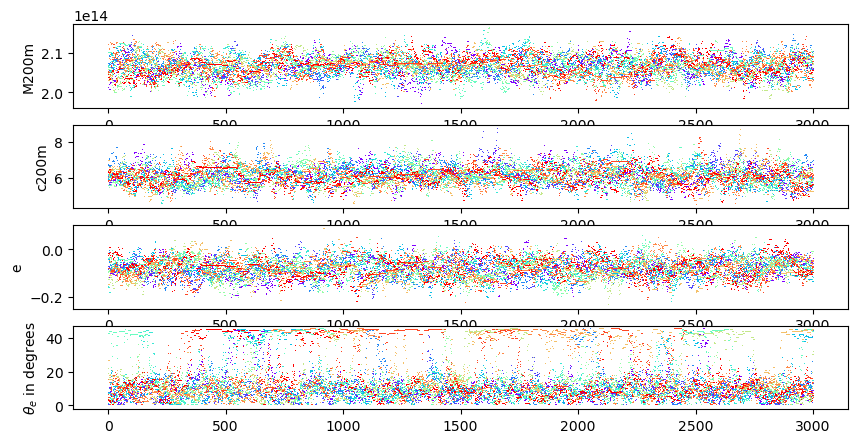

In [56]:
f=None

#MCMC parameters:
params_key=["M200m","c200m","e",r"$\theta_{e}$ in degrees"]
ndim = len(params_key)
nwalkers = ndim*2+4
nsteps = 6000
nburns = 3000
np.random.seed(0)

limits=[[1.0E12,5.0E14],  # mdelta
       [0.0,20.0],     # cdelta
       [-0.99,0.99],   # e
       [0.0, 45.0]]    # theta_e #in degrees
z_cl=0.47
z_gal=0.8
q_true=9.0/10.0 #default = 2/3 for the files in the same directory as this notebook
ell_true= 1*(1-q_true**2)/(1+q_true**2)
theta_e_true = 0.0
true_value=[2.5E14, 3.89055, ell_true,theta_e_true]

'''
Axis ratio q:  0.6666666666666667
c:  3.890554441834905
r200_Mpc: 1.026773208537997
ARCSEC_TO_MPC:  0.00588784182755241
BOX_WIDTH_ARCSEC*ARCSEC_TO_MPC:  5.88784182755241
SIGMA_C=3.77988e+15
arcsec_per_pix:  10.0
'''
# PREP DATA:
ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err,ds_quad_const,ds_quad_const_err,r_quad = make_estimators(gamma1, gamma2, x_arcsec, y_arcsec, z_cl=0.3, 
                                                                                                                      sigma_c=3.77988e+15, method=1)


# CALL EMCEE
post, mean, err_plus, err_minus = emcee_wrapper(gamma1, gamma2, x_arcsec, y_arcsec,z_cl=0.3,
                                                params_key=params_key,limits=limits,true_value=true_value, ndim=ndim,nwalkers=nwalkers,nsteps=nsteps, nburn=nburns, filename=f)

ell_fit =  -0.08246518517681337
[ 6.78285397e+11  4.55906002e+11  2.94390951e+11  1.81167979e+11
  1.04385183e+11  5.38767776e+10  2.15553007e+10  1.37447301e+09
 -1.09560831e+10]


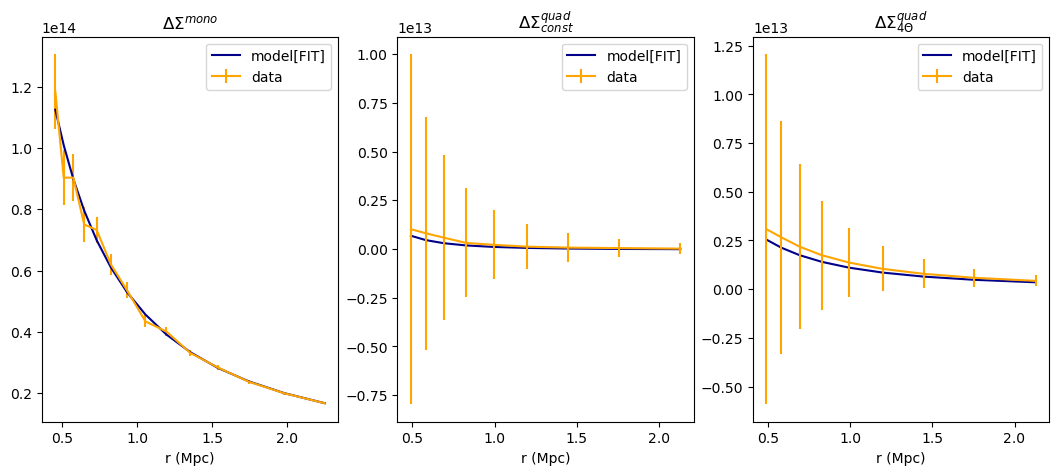

In [60]:
mdelta_fit = mean[0]#2.5E14#
cdelta_fit = mean[1]#3.89#
ell_fit = mean[2]#ell_true#
print("ell_fit = ",ell_fit)
theta_e_fit = mean[3]-0.2 #in degrees
dir_loc = "Elliptical_lenses_data/axis_ratio_9_10/"

gamma1 = np.load(dir_loc+"gamma1.npy").flatten()
gamma2 = np.load(dir_loc+"gamma2.npy").flatten()

x_arcsec = np.load(dir_loc+"x_arcsec.npy").flatten()
y_arcsec = np.load(dir_loc+"y_arcsec.npy").flatten()

theta_e_fit = theta_e_fit*np.pi/180.0
gamma1,gamma2,x_arcsec,y_arcsec = halo_rotation(gamma1,gamma2,x_arcsec,y_arcsec,theta_e_fit)
ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err,ds_quad_const,ds_quad_const_err,r_quad = make_estimators(gamma1, gamma2, x_arcsec, y_arcsec, z_cl=0.47, sigma_c=3.77988e+15)



plt.figure(figsize=[13,5])
plt.subplot(131)
plt.errorbar(r_mono, ds_mono, yerr=np.abs(ds_mono_err), label='data', color='orange')
ds_model = compute_delta_sigma_excess(ell_fit, r_mono, mdelta_fit, cdelta_fit, z_cl, cosmo=cosmo, hpmd='nfw', 
                                             sample_N=1000, delta_mdef=200)
ds_model_without_e_square = clmm.compute_excess_surface_density(r_mono, mdelta_fit, cdelta_fit, z_cl, cosmo, delta_mdef=200, 
                                     halo_profile_model='nfw', massdef='mean', alpha_ein=None, 
                                     verbose=False, validate_input=True)
plt.plot(r_mono, ds_model, label='model[FIT]', color='darkblue')
#plt.plot(r_mono, ds_model_without_e_square-ds_model, label='model*(1+e^2) - model', color='darkblue', ls='dashed')
#plt.yscale('log')
plt.xlabel('r (Mpc)')
plt.title(r'$\Delta\Sigma^{mono}$')
plt.legend()

plt.subplot(132)
ds_model = compute_delta_sigma_const(ell_fit, r_quad, mdelta_fit, cdelta_fit, z_cl=0.3, cosmo=cosmo, hpmd='nfw', 
                                             sample_N=1000, delta_mdef=200)
plt.plot(r_quad, ds_model, label='model[FIT]', color='darkblue')
print(ds_model)
plt.errorbar(r_quad, ds_quad_const,  yerr=ds_quad_const_err, label='data', color='orange')
plt.yscale('linear')
plt.xscale('linear')
plt.title(r'$\Delta\Sigma^{quad}_{const}$')
plt.xlabel('r (Mpc)')
plt.legend()

plt.subplot(133)
ds_model = compute_delta_sigma_4theta(ell_fit, r_quad, mdelta_fit, cdelta_fit, z_cl, cosmo=cosmo, hpmd='nfw', 
                                             sample_N=1000, delta_mdef=200)
plt.plot(r_quad, ds_model, label='model[FIT]', color='darkblue')

plt.errorbar(r_quad, ds_quad_4theta,  yerr=ds_quad_4theta_err, label='data', color='orange')
plt.yscale('linear')
plt.xscale('linear')
plt.title(r'$\Delta\Sigma^{quad}_{4\Theta}$')
plt.xlabel('r (Mpc)')
plt.legend()

[1.0e+13 2.0e+13 3.0e+13 4.0e+13 5.0e+13 6.0e+13 7.0e+13 8.0e+13 9.0e+13
 1.0e+14 1.1e+14 1.2e+14 1.3e+14 1.4e+14 1.5e+14 1.6e+14 1.7e+14 1.8e+14
 1.9e+14 2.0e+14 2.1e+14 2.2e+14 2.3e+14 2.4e+14 2.5e+14 2.6e+14 2.7e+14
 2.8e+14 2.9e+14 3.0e+14 3.1e+14 3.2e+14 3.3e+14 3.4e+14 3.5e+14 3.6e+14
 3.7e+14 3.8e+14 3.9e+14 4.0e+14 4.1e+14 4.2e+14 4.3e+14 4.4e+14 4.5e+14
 4.6e+14 4.7e+14 4.8e+14 4.9e+14 5.0e+14 5.1e+14 5.2e+14 5.3e+14 5.4e+14
 5.5e+14 5.6e+14 5.7e+14 5.8e+14 5.9e+14 6.0e+14 6.1e+14 6.2e+14 6.3e+14
 6.4e+14 6.5e+14 6.6e+14 6.7e+14 6.8e+14 6.9e+14 7.0e+14 7.1e+14 7.2e+14
 7.3e+14 7.4e+14 7.5e+14 7.6e+14 7.7e+14 7.8e+14 7.9e+14 8.0e+14 8.1e+14
 8.2e+14 8.3e+14 8.4e+14 8.5e+14 8.6e+14 8.7e+14 8.8e+14 8.9e+14 9.0e+14
 9.1e+14 9.2e+14 9.3e+14 9.4e+14 9.5e+14 9.6e+14 9.7e+14 9.8e+14 9.9e+14
 1.0e+15]
[-58494.627138733995, -50157.95457360413, -43172.4036943896, -37128.13730970341, -31822.593260328373, -27132.371152183798, -22973.471564914194, -19284.574623792498, -16018.700205673753, -

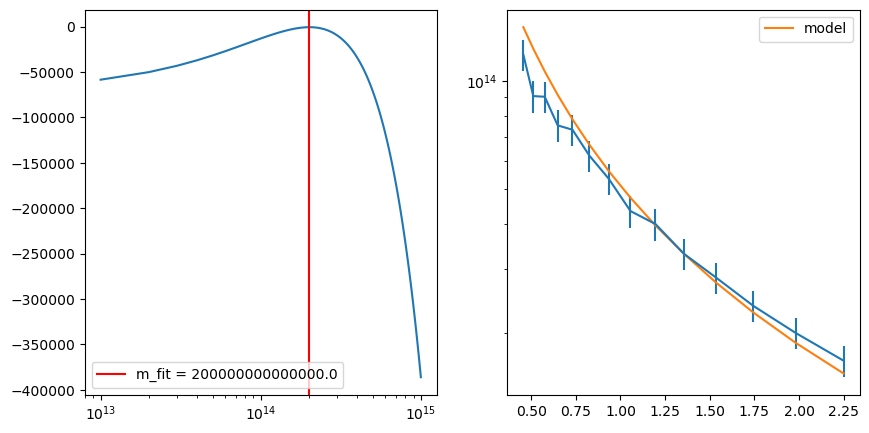

In [14]:
mdelta=1.34E13
cdelta = 12
ell = 0.0
l=[]

def log_likelihood_monopole_temp(params, ds_mono,ds_mono_err, r_mono):
    sigma_c = 3.77988e+15
    z_cl=0.3
    z_gal=1.0
    mdelta = params  # km/s
    ell=0.0
    cdelta=12.0
    ds_data = ds_mono
    
    #model:
    func = np.vectorize(compute_delta_sigma_excess)
    ds_model = func(ell, r_mono, mdelta, cdelta, z_cl, cosmo=cosmo, hpmd='nfw', 
                                             sample_N=1000, delta_mdef=200)#/sigma_c
    
    # Gaussian likelihood:
    #sigma = np.full(len(r_mono), ds_model*0.01) 
    sigma = ds_mono*0.01#np.abs(ds_mono_err)
    term1 = -0.5*np.sum(np.log(2*np.pi*(sigma**2)))
    chi2 = ((ds_data - ds_model)**2 / (sigma)**2)
    term2 = -0.5*np.sum(chi2)

    return (term2)
m_arr=np.linspace(10**13,10**15,10**2)
for mdelta in m_arr:
    params=mdelta
    l.append(log_likelihood_monopole_temp(params, ds_mono,ds_mono_err, r_mono))
    
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(m_arr,l)
plt.axvline(m_arr[np.argmax(l)], color='red', label='m_fit = '+str(m_arr[np.argmax(l)]))
plt.xscale('log')
plt.legend()

plt.subplot(122)
plt.errorbar(r_mono, ds_mono, yerr=np.abs(ds_mono*0.1))

mdelta=m_arr[np.argmax(l)]
print(m_arr)
cdelta = 12
ell = 0.0

ds_model = compute_delta_sigma_excess(ell, r_mono, mdelta, cdelta, z_cl, cosmo=cosmo, hpmd='nfw', 
                                             sample_N=1000, delta_mdef=200)
plt.plot(r_mono, ds_model, label='model')
plt.yscale('log')
plt.legend()

print(l)
mdelta=1E15
ds_model = compute_delta_sigma_excess(ell, r_mono, mdelta, cdelta, z_cl, cosmo=cosmo, hpmd='nfw', 
                                             sample_N=1000, delta_mdef=200)
print(ds_model, ds_mono)
print(-0.5*(ds_model - ds_mono)**2)

In [161]:
from scipy.optimize import minimize
res = minimize(log_likelihood_monopole_temp, [14.0E14], args=(ds_mono,ds_mono_err, r_mono), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), 
                        tol=None, callback=None, options=None)

print(res)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -1751919.354392614
        x: [ 1.400e+15]
      nit: 0
      jac: [-2.129e-09]
 hess_inv: [[1]]
     nfev: 2
     njev: 1


In [185]:
mdelta=[0.0001]
r=[0.1,1.0]
func = np.vectorize(clmm.compute_excess_surface_density)
func(r, mdelta, cdelta, z_cl, cosmo, delta_mdef=200, 
                                     halo_profile_model='nfw', massdef='mean', alpha_ein=None, 
                                     verbose=False, validate_input=True)

array([0.02464215, 0.00029106])